# CS4055 Project

### Naichuan Zhang
### Predictive Modelling


## Import Python modules

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from itertools import cycle

from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from scipy import interp

%matplotlib inline

In [31]:
df = pd.read_csv('./african_crises.csv')

In [32]:
df.head()

,case,cc3,country,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,inflation_annual_cpi,independence,currency_crises,inflation_crises,banking_crisis
0,1,DZA,Algeria,1870,1,0.052264,0,0,0.0,3.441456,0,0,0,crisis
1,1,DZA,Algeria,1871,0,0.052798,0,0,0.0,14.149140,0,0,0,no_crisis
2,1,DZA,Algeria,1872,0,0.052274,0,0,0.0,-3.718593,0,0,0,no_crisis
3,1,DZA,Algeria,1873,0,0.051680,0,0,0.0,11.203897,0,0,0,no_crisis
4,1,DZA,Algeria,1874,0,0.051308,0,0,0.0,-3.848561,0,0,0,no_crisis


In [33]:
df.describe()

,case,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,inflation_annual_cpi,independence,currency_crises,inflation_crises
count,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1.059000e+03,1059.000000,1059.000000,1059.000000
mean,35.613787,1967.767705,0.077432,43.140831,0.039660,0.152975,0.006402,2.084889e+04,0.776204,0.132200,0.129367
std,23.692402,33.530632,0.267401,111.475380,0.195251,0.360133,0.043572,6.757274e+05,0.416984,0.349847,0.335765
min,1.000000,1860.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.850214e+01,0.000000,0.000000,0.000000
25%,15.000000,1951.000000,0.000000,0.195350,0.000000,0.000000,0.000000,2.086162e+00,1.000000,0.000000,0.000000
50%,38.000000,1973.000000,0.000000,0.868400,0.000000,0.000000,0.000000,5.762330e+00,1.000000,0.000000,0.000000
75%,56.000000,1994.000000,0.000000,8.462750,0.000000,0.000000,0.000000,1.164405e+01,1.000000,0.000000,0.000000
max,70.000000,2014.000000,1.000000,744.306139,1.000000,1.000000,0.400000,2.198970e+07,1.000000,2.000000,1.000000


## Data Preparation

Before training and evaluating models, we need to do some data preparation first. We can see that attributes `cc3` and `country` are redundant since we have an attribute `case` to uniquely identify a specific country. So let's drop them.

In [34]:
df = df.drop(['cc3', 'country'], axis=1)

In [35]:
df.head()

,case,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,inflation_annual_cpi,independence,currency_crises,inflation_crises,banking_crisis
0,1,1870,1,0.052264,0,0,0.0,3.441456,0,0,0,crisis
1,1,1871,0,0.052798,0,0,0.0,14.149140,0,0,0,no_crisis
2,1,1872,0,0.052274,0,0,0.0,-3.718593,0,0,0,no_crisis
3,1,1873,0,0.051680,0,0,0.0,11.203897,0,0,0,no_crisis
4,1,1874,0,0.051308,0,0,0.0,-3.848561,0,0,0,no_crisis


Then, we can also do some modification on `banking_crisis`. Converting 'crisis' and 'no_crisis' to 1 and 0, respectively.

In [36]:
df = df.replace({'banking_crisis': {'crisis': 1, 'no_crisis': 0}})

In [37]:
df.head()

,case,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,inflation_annual_cpi,independence,currency_crises,inflation_crises,banking_crisis
0,1,1870,1,0.052264,0,0,0.0,3.441456,0,0,0,1
1,1,1871,0,0.052798,0,0,0.0,14.149140,0,0,0,0
2,1,1872,0,0.052274,0,0,0.0,-3.718593,0,0,0,0
3,1,1873,0,0.051680,0,0,0.0,11.203897,0,0,0,0
4,1,1874,0,0.051308,0,0,0.0,-3.848561,0,0,0,0


## Training Models

In [38]:
# target attribute
target = df['banking_crisis']

# predictor attributes
predictors = df.drop('banking_crisis', axis=1).values

Let's prepare an array of 100 equally spaced false-positive-rate values between 0 and 1, which will be used as an x-axis in ROC curve plots.

In [39]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

Then, we need to import evaluation and plotting functions.

In [40]:
%run ./Functions.ipynb

The scaler is used to scale all predictor values to the range [0, 1]

In [41]:
min_max_scaler = preprocessing.MinMaxScaler()

### Train a k-Nearest Neighbors Classifier

In [42]:
# create a k-Nearest Neighbors classifier
KNN_classifier = KNeighborsClassifier(n_neighbors=1)

accuracies_KNN, f1_scores_KNN, tprs_KNN, aucs_KNN = evaluate_classifier(folds=5, 
                                                                    p=predictors, t=target, 
                                                                    classifier=KNN_classifier, 
                                                                    mean_fpr=mean_fpr)

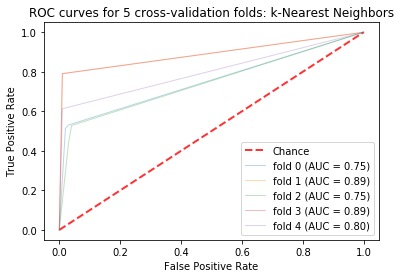

In [43]:
plot_roc_cv_folds(mean_fpr, tprs_KNN, aucs_KNN, 'k-Nearest Neighbors')

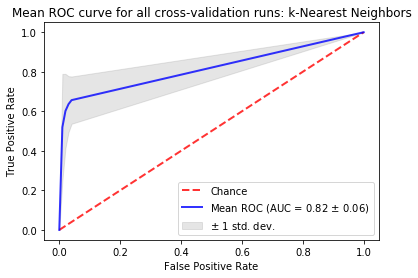

In [44]:
plot_roc_mean(mean_fpr, tprs_KNN, aucs_KNN, 'k-Nearest Neighbors')

### Train a Random Forest Classifier

In [45]:
# create a Random Forest classifier object
RF_classifier = RandomForestClassifier()

accuracies_RF, f1_scores_RF, tprs_RF, aucs_RF = evaluate_classifier(folds=5, 
                                                                    p=predictors, 
                                                                    t=target, 
                                                                    classifier=RF_classifier, 
                                                                    mean_fpr=mean_fpr)

D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


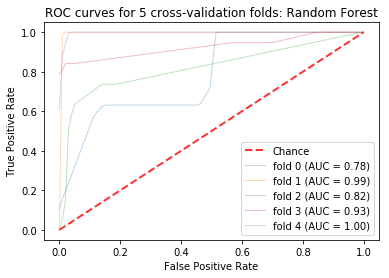

In [46]:
plot_roc_cv_folds(mean_fpr, tprs_RF, aucs_RF, 'Random Forest')

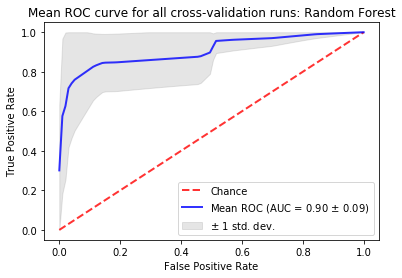

In [47]:
plot_roc_mean(mean_fpr, tprs_RF, aucs_RF, 'Random Forest')

## Compare All Trained Classifiers

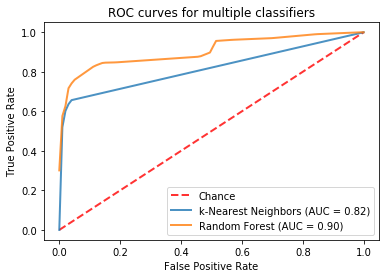

In [48]:
plot_roc_multiple_classifiers(mean_fpr,
                             np.stack((np.mean(tprs_KNN, axis=0), np.mean(tprs_RF, axis=0))),
                             np.array([np.mean(aucs_KNN), np.mean(aucs_RF)]),
                             np.array(['k-Nearest Neighbors', 'Random Forest']))

In [49]:
# compare the statistics of the accuracies across all cross-validation folds

accuracies_df = pd.DataFrame(data={'k-Nearest Neighbors': accuracies_KNN,
                                   'Random Forest': accuracies_RF})

In [50]:
accuracies_df.describe()

,k-Nearest Neighbors,Random Forest
count,5.000000,5.000000
mean,0.955625,0.932988
std,0.023240,0.045386
min,0.924528,0.858491
25%,0.938679,0.929245
50%,0.962085,0.938679
75%,0.976415,0.966825
max,0.976415,0.971698


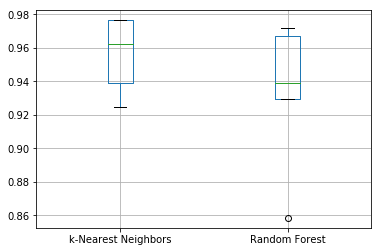

In [51]:
accuracies_df.boxplot()

In [52]:
# compare the statistics of the f1-scores across all cross-validation folds

f1_scores_df = pd.DataFrame(data={'k-Nearest Neighbors': f1_scores_KNN,
                                  'Random Forest': f1_scores_RF})

In [53]:
f1_scores_df.describe()

,k-Nearest Neighbors,Random Forest
count,5.000000,5.000000
mean,0.721847,0.652359
std,0.139464,0.164348
min,0.555556,0.423077
25%,0.606061,0.545455
50%,0.733333,0.711111
75%,0.857143,0.758621
max,0.857143,0.823529


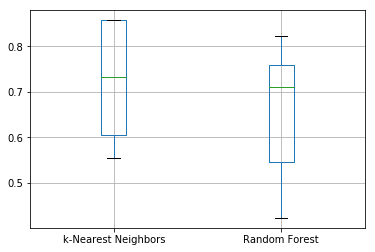

In [54]:
f1_scores_df.boxplot()